## Black-Scholes Model
Purpose: Determine fair value of an options contract.

**BS Formula**:

**1. Call Option**

$$C(S,t) = S_t N(d_1) - K e^{-r(T-t)} N(d_2)$$

**2. Put Option**:

$$P(S,t) = K e^{-r(T-t)} N(-d_2) - S_t N(-d_1)$$

where:
- Asset Price ($S_t$) = Current price of the stock
- Strike Price ($K$)  = Price at which you can buy the stock in the future
- Time to Expiration ($T$)  = Time until the option expires (years)
- Risk Free Rate ($r$)  = Interest rate earn with zero risk
- Normal Distribution ($N(d)$) =  Cummulative normal distribution function of the standard normal distribution

**Normal Cummulative Distribution**:

$$N(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-t^2/2} dt$$

Error function defined as:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt$$

Thus, it can be rewritten as:
$$N(x) = \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$$

**d1 & d2 Calculations**:

$$d_1 = \frac{\log(S_t/K) + (r + \sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2 = d_1 - \sigma\sqrt{T-t}$$

where:
- $\sigma$ = Volatility (standard deviation of returns)


**Put-Call Parity**:

$$C - P = S_t - K e^{-r(T-t)}$$

or equivalently:

$$P = C - S_t + K e^{-r(T-t)}$$

## Monte Carlo Model
Purpose: Estimate option price by simulating possible future prices


In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import pandas as pd
from math import log, sqrt, exp, erf

# NORMAL CUMMULATIVE DISTRIBUTION FUNCTION

In [2]:
def normaCummulativelDistribution(x):
    return (1.0 + erf((x/sqrt(2.0)))) / 2.0

# BLACK SCHOLES MODEL

In [66]:
def blackScholes(S, K, T, r, sigma, opt_type):
    if T <= 0 or sigma <= 0:
        intrinsic = max(S - K, 0.0) if opt_type == "call" else max(K - S, 0.0)
        return intrinsic

    d1 = (log(S/K) + (r + (sigma)**2/2.0)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma * (sqrt(T))

    if(opt_type == "call"):
        return (S * normaCummulativelDistribution(d1)) - (K * exp(-r * T) * normaCummulativelDistribution(d2))
    else:
        return (K * exp(-r * T) * normaCummulativelDistribution(-d2)) - (S * normaCummulativelDistribution(-d1))

# MONTE CARLO MODEL

In [67]:
def monteCarlo(S, K, T, r, sigma, opt_type, num_simulations=20000, seed=0):
    randomNumber = np.random.RandomState(seed)
    Z = randomNumber.standard_normal(num_simulations)
    ST = S * np.exp((r - (sigma**2)/2.0)*T + sigma*np.sqrt(T)*Z)

    if opt_type == "call":
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    price = exp(-r * T) * payoff.mean()
    se = exp(-r * T) * payoff.std() / np.sqrt(num_simulations)
    return price, se

## DATASET

Goldman Scahs Option Stocks
Source: https://www.kaggle.com/datasets/mohantys/gs-option-prices/data

In [68]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('option_GS_df.csv')
df.columns = df.columns.str.strip()
df.head(5)

,Unnamed: 0,UnderlyingPrice,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA
0,0,174.09,GS160108C00125000,call,01/08/2016,01/05/2016,125.0,0.0,46.95,50.80,0,0,0,0.0874,0.0,3.1911,1.0000,0.0000,0.0000,0.0000,GS160108C00125000
1,1,174.09,GS160108P00125000,put,01/08/2016,01/05/2016,125.0,0.0,0.00,0.31,0,0,0,1.9822,0.0,2.2141,-0.0150,0.0014,-0.2242,0.0053,GS160108P00125000
2,2,174.09,GS160108C00130000,call,01/08/2016,01/05/2016,130.0,0.0,41.80,45.80,0,0,0,0.0874,0.0,2.8946,1.0000,0.0000,0.0000,0.0000,GS160108C00130000
3,3,174.09,GS160108P00130000,put,01/08/2016,01/05/2016,130.0,0.0,0.00,0.31,0,0,0,1.7931,0.0,1.9882,-0.0175,0.0017,-0.2310,0.0060,GS160108P00130000
4,4,174.09,GS160108C00135000,call,01/08/2016,01/05/2016,135.0,0.0,36.95,40.90,0,0,0,0.0874,0.0,2.6480,1.0000,0.0000,0.0000,0.0000,GS160108C00135000


**T**: Time to Expiration

In [69]:
df["Expiration"] = pd.to_datetime(df["Expiration"], format="%m/%d/%Y")
df["DataDate"] = pd.to_datetime(df["DataDate"], format="%m/%d/%Y")
df["T"] = (df["Expiration"] - df["DataDate"]).dt.days/365.0
df["T"].head(5)

0    0.008219
1    0.008219
2    0.008219
3    0.008219
4    0.008219
Name: T, dtype: float64

**Mid Value** : Taking middle value between Bid and Ask as the estimation of market value

In [70]:
bid = df['Bid'].astype(float)
ask = df['Ask'].astype(float)
mid = np.where(((bid>0) & (ask>0)), (bid+ask)/2.0, ask)
df["Mid"] = mid
df["Mid"].head(5)

0    48.875
1     0.310
2    43.800
3     0.310
4    38.925
Name: Mid, dtype: float64

In [71]:
df["Sigma"] = df["IVMean"].astype(float)
df.loc[df["Sigma"] > 3.0, "Sigma"] = df.loc[df["Sigma"] > 3.0, "Sigma"]/100.0
df["Sigma"].head(5)

0    0.0874
1    1.9822
2    0.0874
3    1.7931
4    0.0874
Name: Sigma, dtype: float64

In [72]:
r = 0.1

**Black Scholes in a nutshell**: Probability estimation of the prices to end above strike prices based on how much the stock can wiggle before expiration

In [ ]:
df["BSModel"] = df.apply(
    lambda x: blackScholes(
        x["UnderlyingPrice"], 
        x["Strike"], 
        x["T"], 
        r, 
        x["Sigma"], 
        x["Type"]
    ), 
    axis=1
)

0    49.192698
1     0.333960
2    44.196805
3     0.346758
4    39.200913
Name: BSModel, dtype: float64

**Monte Carlo in a nutshell**: Estimation of the result based on the number of simulation

In [74]:
monteCarlo_Prices, monteCarlo_Se = [] ,[]
for i, row in df.iterrows():
    price, se = monteCarlo(
        row["UnderlyingPrice"], 
        row["Strike"], 
        row["T"], 
        r, 
        row["Sigma"], 
        row["Type"],
        num_simulations=20000,
        seed = 44
    )
    monteCarlo_Prices.append(price)
    monteCarlo_Se.append(se)

df["MCModel"] = monteCarlo_Prices
df["MCSe"] = monteCarlo_Se

In [75]:
df["BSError"] = df["BSModel"] - df["Mid"]
df["MCError"] = df["MCModel"] - df["Mid"]
df.to_csv("gs_pricing_comparison.csv", index=False)
print(df[["Mid","BSModel","MCModel","MCSe","BSError","MCError"]].head())

      Mid    BSModel    MCModel      MCSe   BSError   MCError
0  48.875  49.192698  49.182459  0.009772  0.317698  0.307459
1   0.310   0.333960   0.341400  0.015659  0.023960  0.031400
2  43.800  44.196805  44.186566  0.009772  0.396805  0.386566
3   0.310   0.346758   0.353774  0.015606  0.036758  0.043774
4  38.925  39.200913  39.190674  0.009772  0.275913  0.265674


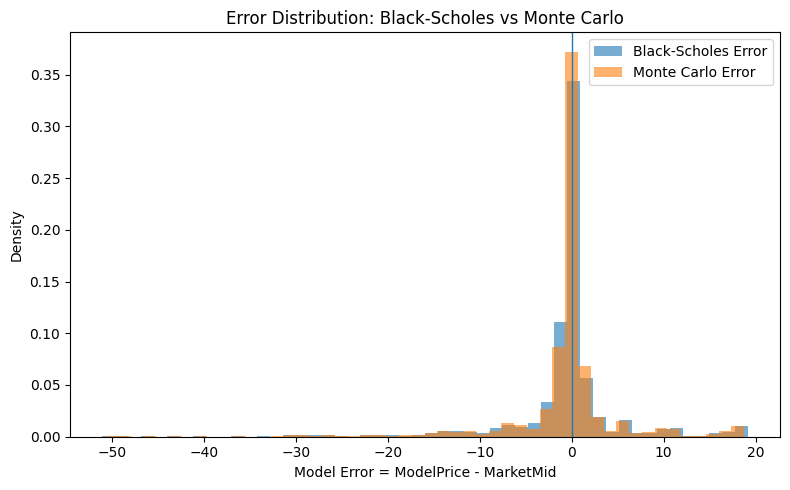

In [ ]:
plt.figure(figsize=(8, 5))

bins = 50 
plt.hist(df["BSError"], bins=bins, alpha=0.6, density=True, label="Black-Scholes Error")
plt.hist(df["MCError"], bins=bins, alpha=0.6, density=True, label="Monte Carlo Error")

plt.axvline(0, linewidth=1)
plt.title("Error Distribution: Black-Scholes vs Monte Carlo")
plt.xlabel("Model Error = ModelPrice - MarketMid")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

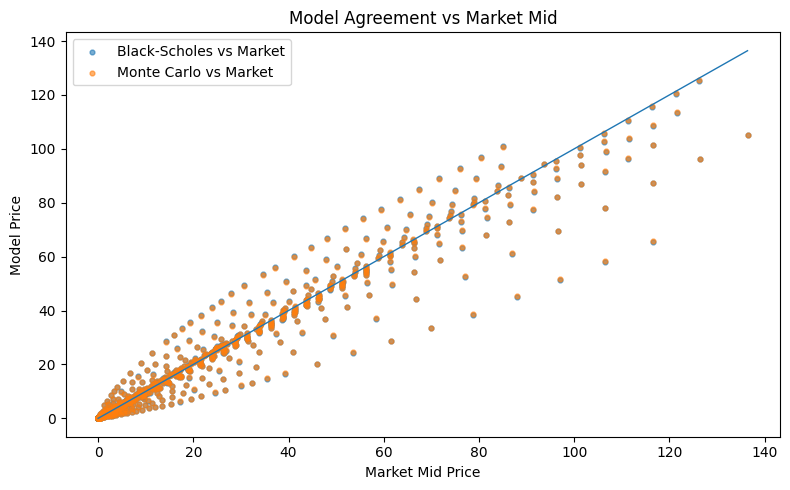

In [78]:
plt.figure(figsize=(8, 5))

plt.scatter(df["Mid"], df["BSModel"], s=12, alpha=0.6, label="Black-Scholes vs Market")
plt.scatter(df["Mid"], df["MCModel"], s=12, alpha=0.6, label="Monte Carlo vs Market")

minv = min(df["Mid"].min(), df["BSModel"].min(), df["MCModel"].min())
maxv = max(df["Mid"].max(), df["BSModel"].max(), df["MCModel"].max())
plt.plot([minv, maxv], [minv, maxv], linewidth=1)

plt.title("Model Agreement vs Market Mid")
plt.xlabel("Market Mid Price")
plt.ylabel("Model Price")
plt.legend()
plt.tight_layout()
plt.show()

This analysis compared the classical analytical model (**Black-Scholes**) and computational Model (**Monte Carlo**) approaches to option valuation with using Goldman Sachs Market Data (*Source: https://www.kaggle.com/datasets/mohantys/gs-option-prices/data*). From the experiment the pricing error relative to the estimation of the market reveal the model accuracy accross different option types.